In [1]:
import random
import time
import numpy as np

import GameHard
import DisplayIA

env = GameHard.Game()

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib.pyplot as plt


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
n_actions = 3

def fit_batch(model, batch):
    """Do one deep Q learning iteration.
    
    Params:
    - model: The DQN
    - gamma: Discount factor (should be 0.99)
    - start_states: numpy array of starting states
    - actions: numpy array of one-hot encoded actions corresponding to the start states
    - rewards: numpy array of rewards corresponding to the start states and actions
    - next_states: numpy array of the resulting states corresponding to the start states and actions
    - is_terminal: numpy boolean array of whether the resulting state is terminal
    
    """
    start_states, actions, next_states, rewards, is_terminal = batch
    
    gamma = 0.99
    # First, predict the Q values of the next states. Note how we are passing ones as the mask.
    actions = keras.utils.to_categorical(actions, n_actions)#tf.one_hot(actions.tolist(), n_actions)
    next_Q_values = target.predict([next_states, np.ones(actions.shape)])
    # The Q values of the terminal states is 0 by definition, so override them
    next_Q_values[is_terminal] = 0
    # The Q values of each start state is the reward + gamma * the max next state Q value
    Q_values = rewards + gamma * np.max(next_Q_values, axis=1)
    # Fit the keras model. Note how we are passing the actions as the mask and multiplying
    # the targets by the actions.
    model.fit(
        [start_states, actions], actions * Q_values[:, None],
        epochs=1, batch_size=len(start_states), verbose=0
    )

In [3]:
def copy_model(model):
    """Returns a copy of a keras model."""
    model.save('tmp_model')
    return keras.models.load_model('tmp_model')


def huber_loss(a, b, in_keras=True):
    error = a - b
    quadratic_term = error*error / 2
    linear_term = abs(error) - 1/2
    use_linear_term = (abs(error) > 1.0)
    if in_keras:
        # Keras won't let us multiply floats by booleans, so we explicitly cast the booleans to floats
        use_linear_term = tf.keras.backend.cast(use_linear_term, 'float32')
    return use_linear_term * linear_term + (1-use_linear_term) * quadratic_term

# We assume a theano backend here, so the "channels" are first.
YOUSHI_SHAPE = [15, 2]

# With the functional API we need to define the inputs.
frames_input = keras.layers.Input(YOUSHI_SHAPE, name='frames')
actions_input = keras.layers.Input((n_actions,), name='mask')

# Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
normalized = keras.layers.Lambda(lambda x: x / 1000.0)(frames_input)

flatten = keras.layers.Flatten(input_shape=YOUSHI_SHAPE)(normalized)
dense_1 = keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.VarianceScaling())(flatten)
dense_2 = keras.layers.Dense(200, activation="relu", kernel_initializer=keras.initializers.VarianceScaling())(dense_1)
dense_3 = keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.VarianceScaling())(dense_2)


# "The output layer is a fully-connected linear layer with a single output for each valid action."
output = keras.layers.Dense(n_actions)(dense_3)
# Finally, we multiply the output by the mask!
filtered_output = keras.layers.Multiply()([output, actions_input])

model = keras.models.Model(inputs=[frames_input, actions_input], outputs=filtered_output)
optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True)
model.compile(optimizer, loss=huber_loss)

target = copy_model(model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: tmp_model\assets


In [4]:
class RingBuf:
    def __init__(self, size):
        # Pro-tip: when implementing a ring buffer, always allocate one extra element,
        # this way, self.start == self.end always means the buffer is EMPTY, whereas
        # if you allocate exactly the right number of elements, it could also mean
        # the buffer is full. This greatly simplifies the rest of the code.
        self.data = [None] * (size + 1)
        self.start = 0
        self.end = 0
        
    def append(self, element):
        self.data[self.end] = element
        self.end = (self.end + 1) % len(self.data)
        # end == start and yet we just added one element. This means the buffer has one
        # too many element. Remove the first element by incrementing start.
        if self.end == self.start:
            self.start = (self.start + 1) % len(self.data)
        
    def __getitem__(self, idx):
        return self.data[(self.start + idx) % len(self.data)]
    
    def __len__(self):
        if self.end < self.start:
            return self.end + len(self.data) - self.start
        else:
            return self.end - self.start
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]
            
from collections import deque            
replay_buffer = deque(maxlen=100000)

In [5]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [6]:
#Play random for a few episodes
for episode in range(1000):
    state = env.reset()
    
    repeat = 0
    action_to_repeat = 0

    for step in range(5000):
        
        action = action_to_repeat
        if repeat == 0 :
            # Choose the action 
            action = np.random.randint(3)
            action_to_repeat = action
            repeat = 3
        else :
            repeat -= 1
        
        new_frame, reward, is_done, _ = env.step(action)
        replay_buffer.append((state, action, new_frame, reward, is_done))
        if is_done:
            obs = env.reset()
            break
    
    if episode % 1000 == 0:
        print(episode)

0


INFO:tensorflow:Assets written to: tmp_model\assets
step number : 0
episode number : 0


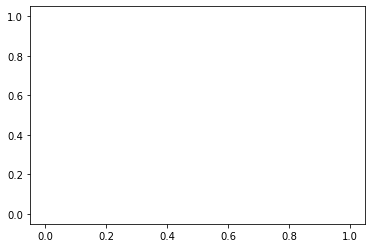

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 10000
episode number : 97


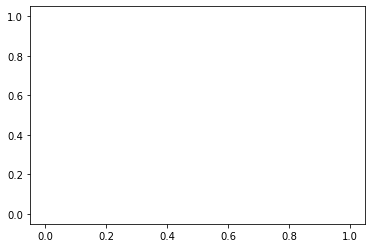

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 20000
episode number : 195


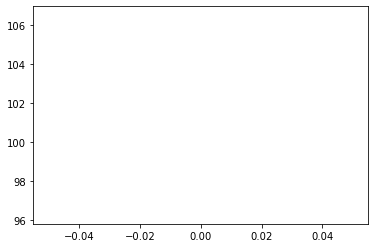

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 30000
episode number : 298


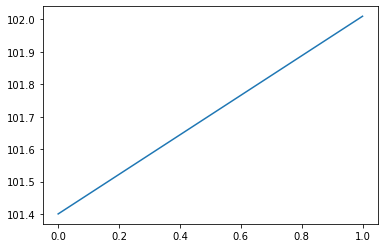

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 40000
episode number : 391


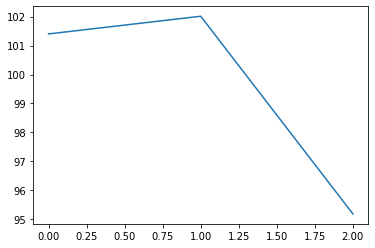

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 50000
episode number : 486


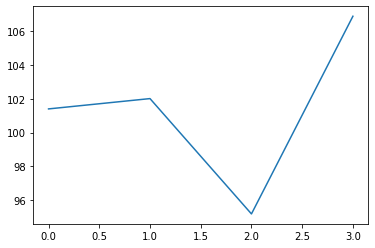

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 60000
episode number : 577


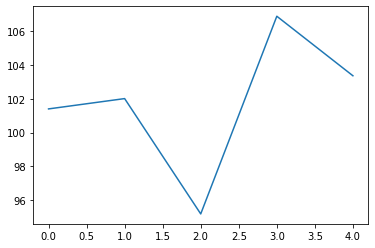

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 70000
episode number : 676


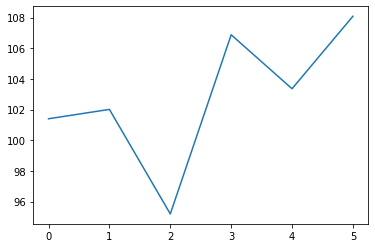

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 80000
episode number : 768


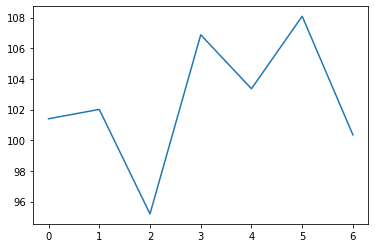

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 90000
episode number : 862


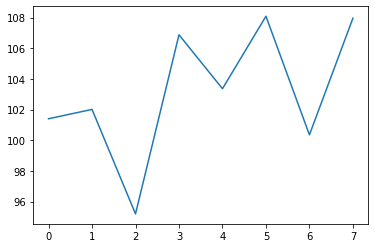

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 100000
episode number : 958


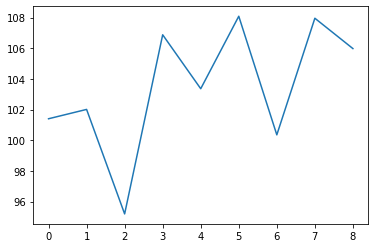

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 110000
episode number : 1060


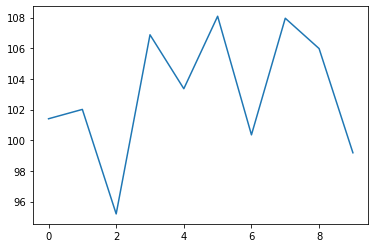

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 120000
episode number : 1153


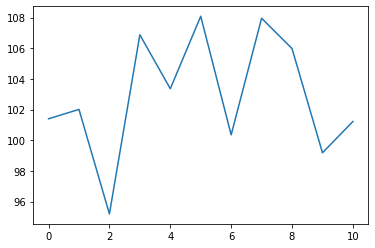

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 130000
episode number : 1243


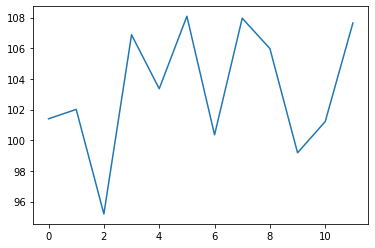

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 140000
episode number : 1338


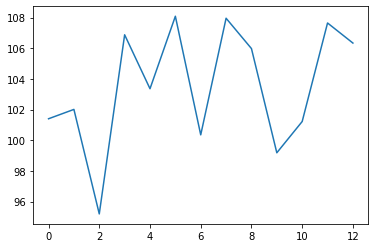

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 150000
episode number : 1435


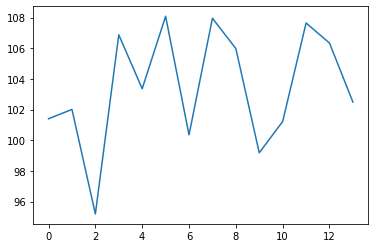

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 160000
episode number : 1524


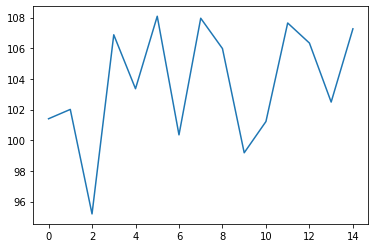

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 170000
episode number : 1615


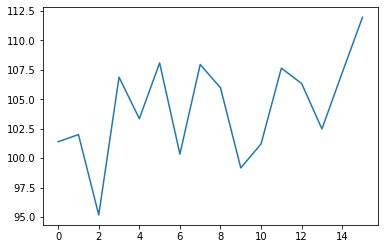

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 180000
episode number : 1714


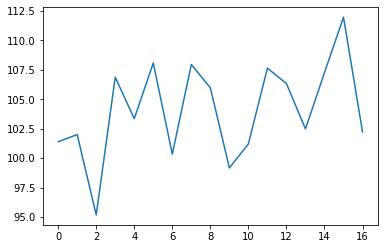

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 190000
episode number : 1810


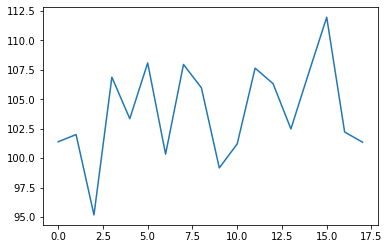

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 200000
episode number : 1899


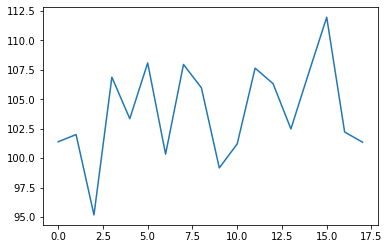

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 210000
episode number : 1992


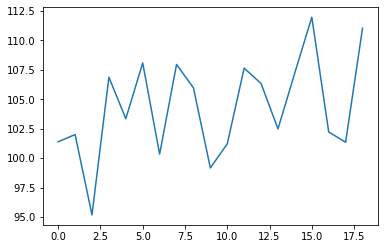

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 220000
episode number : 2081


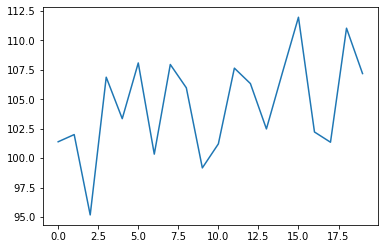

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 230000
episode number : 2171


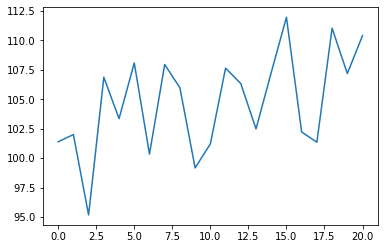

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 240000
episode number : 2271


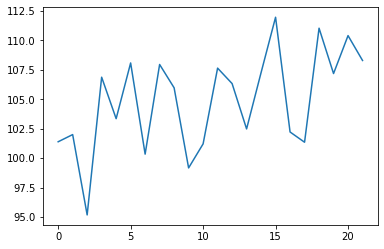

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 250000
episode number : 2367


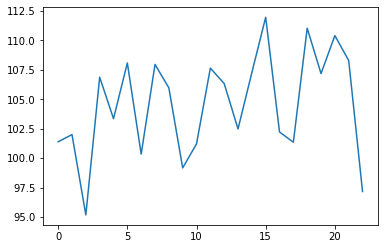

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 260000
episode number : 2455


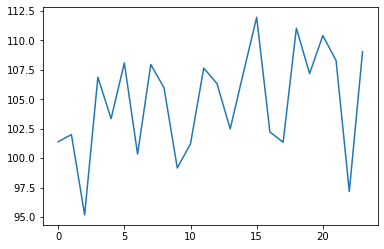

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 270000
episode number : 2554


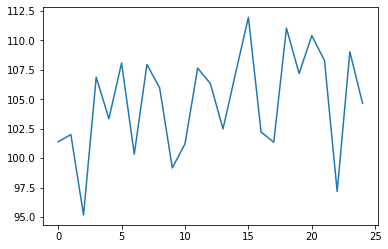

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 280000
episode number : 2651


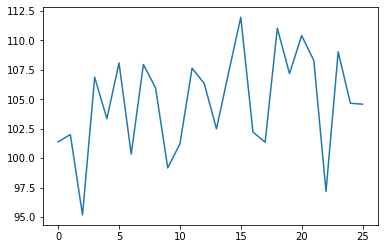

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 290000
episode number : 2748


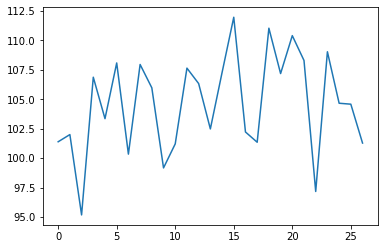

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 300000
episode number : 2842


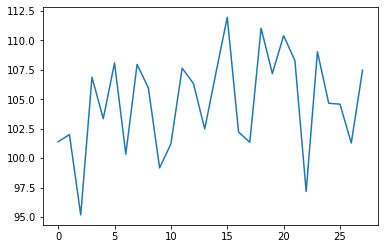

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 310000
episode number : 2933


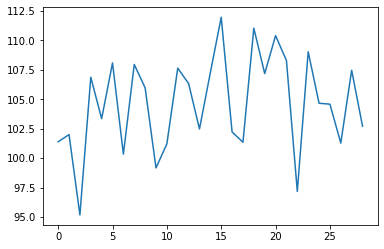

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 320000
episode number : 3029


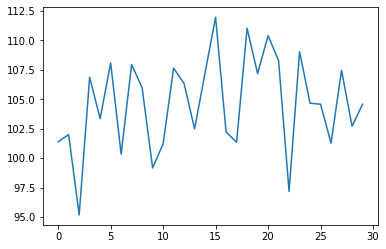

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 330000
episode number : 3126


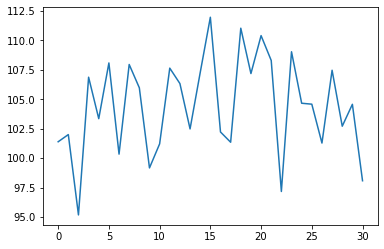

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 340000
episode number : 3217


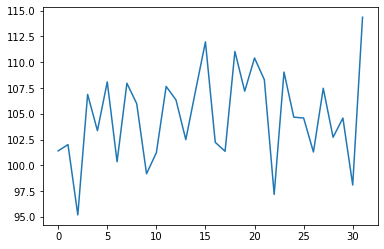

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 350000
episode number : 3315


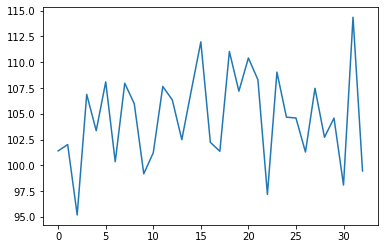

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 360000
episode number : 3409


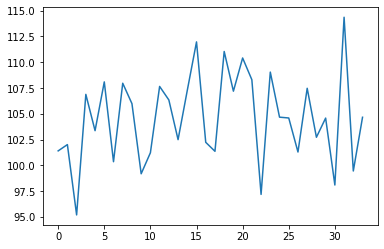

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 370000
episode number : 3502


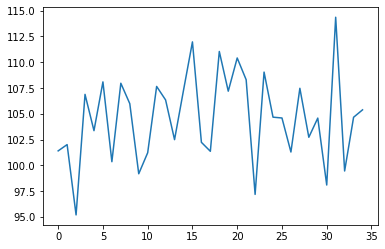

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 380000
episode number : 3596


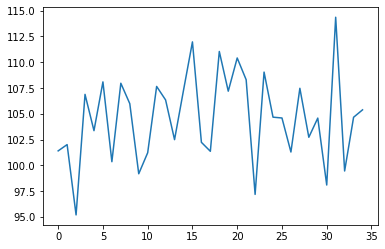

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 390000
episode number : 3700


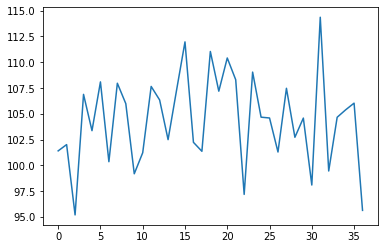

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 400000
episode number : 3792


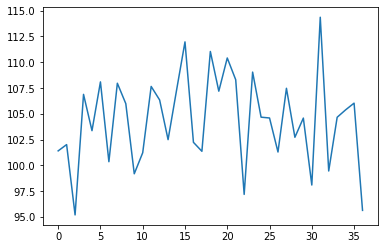

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 410000
episode number : 3888


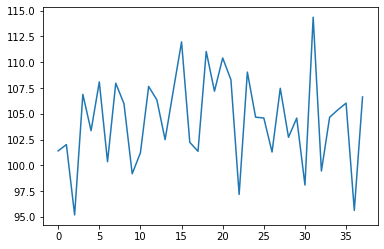

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 420000
episode number : 3983


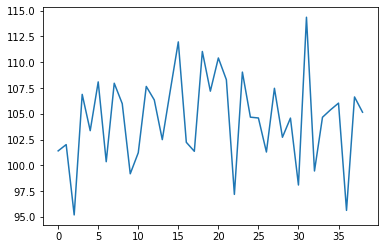

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 430000
episode number : 4075


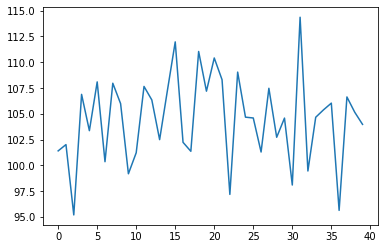

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 440000
episode number : 4170


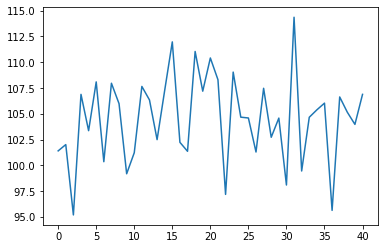

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 450000
episode number : 4258


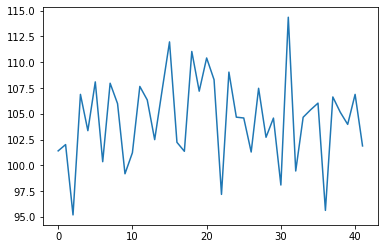

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 460000
episode number : 4351


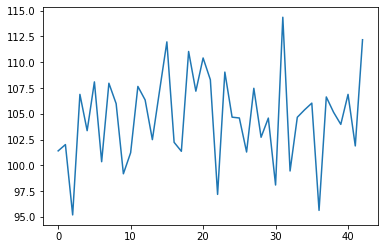

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 470000
episode number : 4448


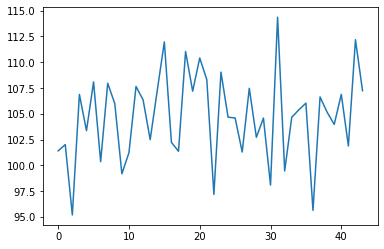

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 480000
episode number : 4540


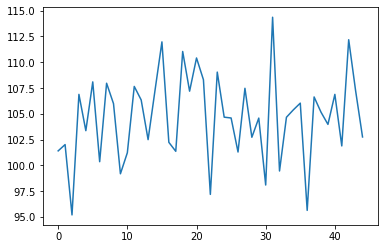

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 490000
episode number : 4633


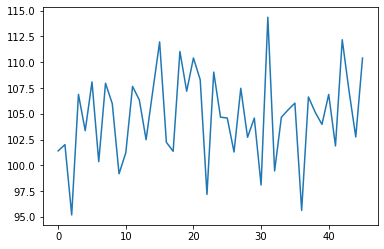

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 500000
episode number : 4724


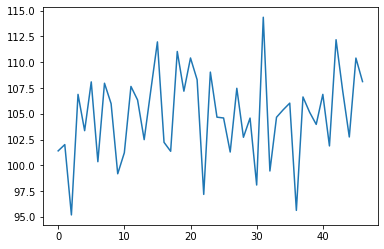

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 510000
episode number : 4816


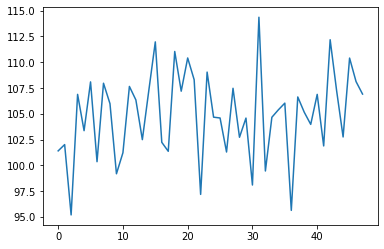

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 520000
episode number : 4914


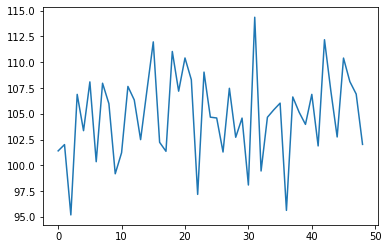

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 530000
episode number : 5005


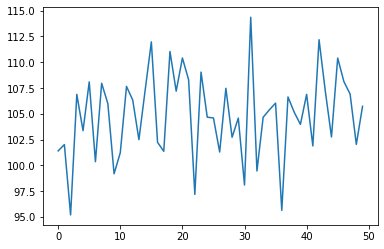

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 540000
episode number : 5100


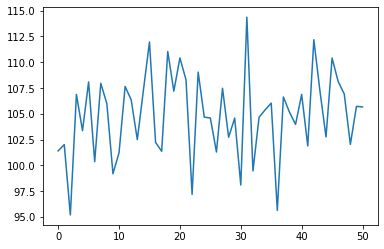

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 550000
episode number : 5190


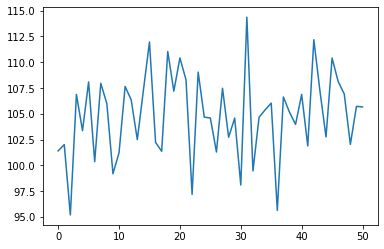

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 560000
episode number : 5282


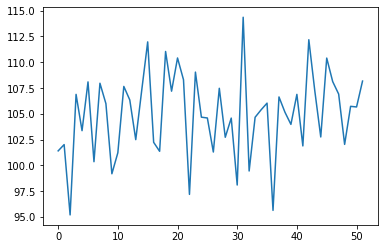

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 570000
episode number : 5377


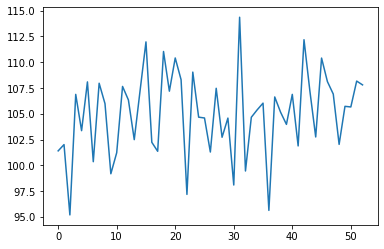

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 580000
episode number : 5471


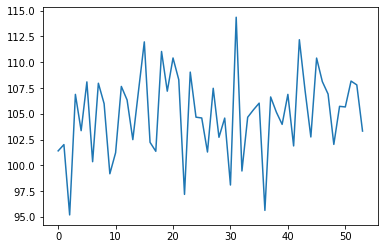

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 590000
episode number : 5566


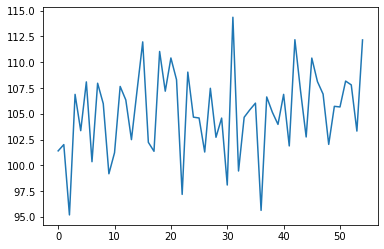

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 600000
episode number : 5659


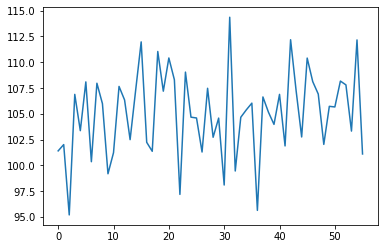

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 610000
episode number : 5750


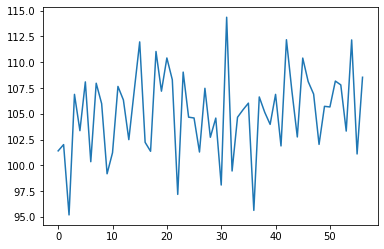

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 620000
episode number : 5843


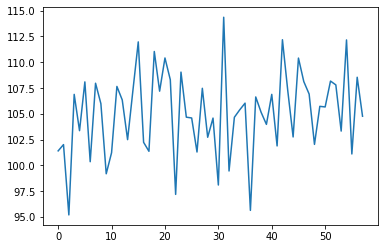

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 630000
episode number : 5935


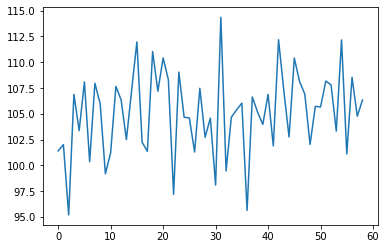

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 640000
episode number : 6023


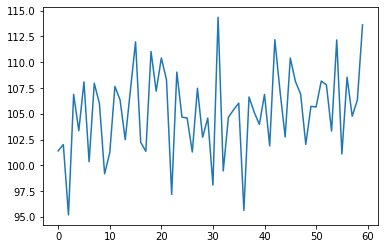

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 650000
episode number : 6116


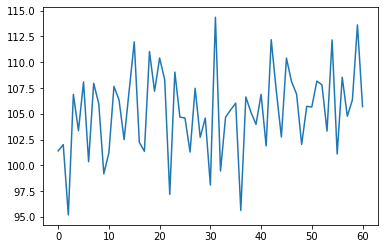

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 660000
episode number : 6203


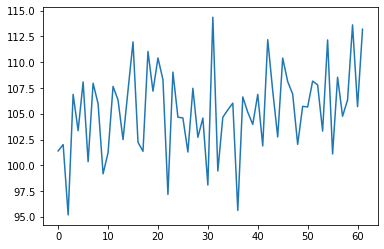

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 670000
episode number : 6295


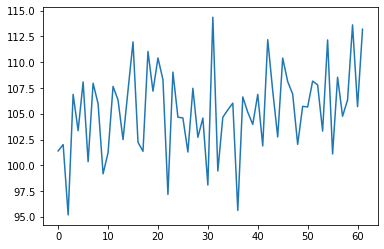

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 680000
episode number : 6389


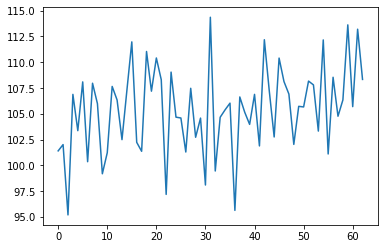

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 690000
episode number : 6480


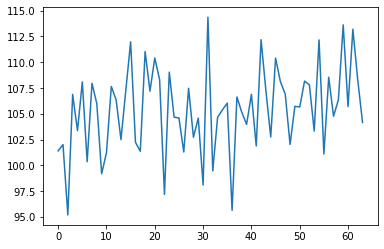

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 700000
episode number : 6576


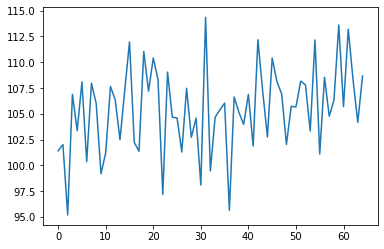

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 710000
episode number : 6664


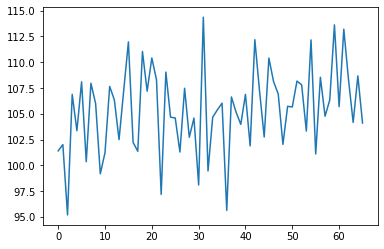

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 720000
episode number : 6750


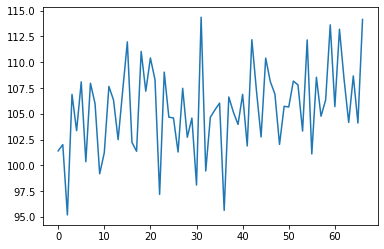

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 730000
episode number : 6841


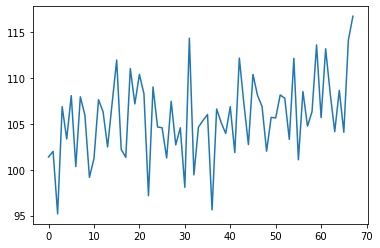

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 740000
episode number : 6924


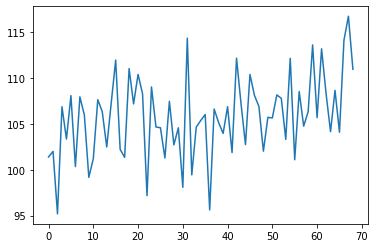

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 750000
episode number : 7013


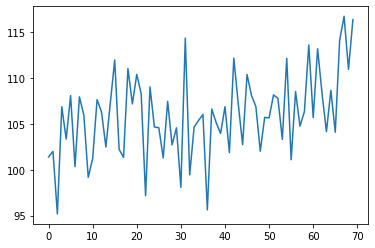

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 760000
episode number : 7109


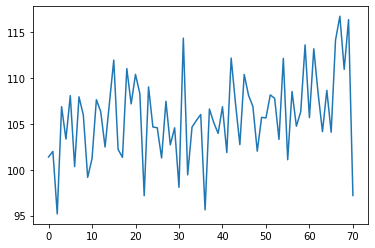

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 770000
episode number : 7207


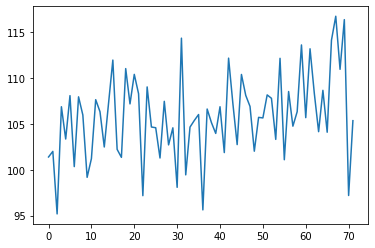

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 780000
episode number : 7295


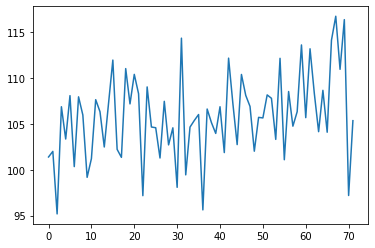

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 790000
episode number : 7387


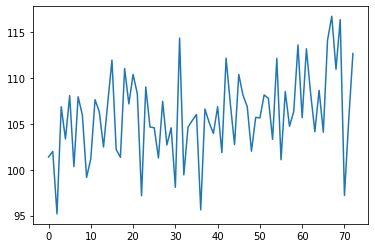

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 800000
episode number : 7475


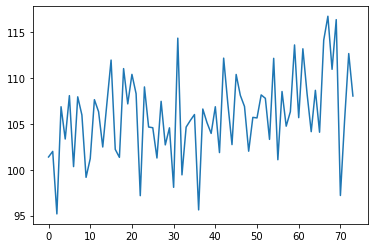

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 810000
episode number : 7565


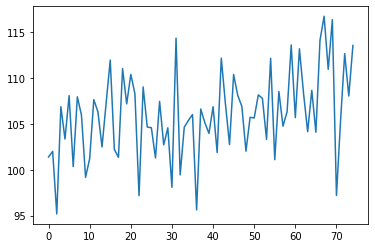

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 820000
episode number : 7658


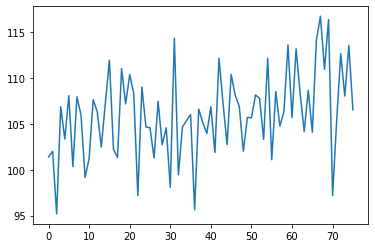

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 830000
episode number : 7746


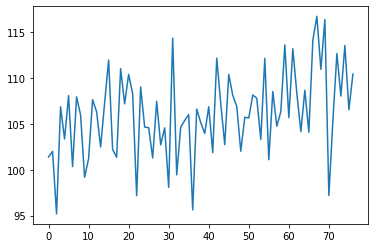

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 840000
episode number : 7841


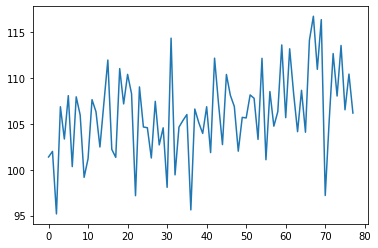

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 850000
episode number : 7927


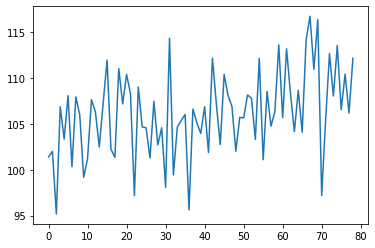

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 860000
episode number : 8020


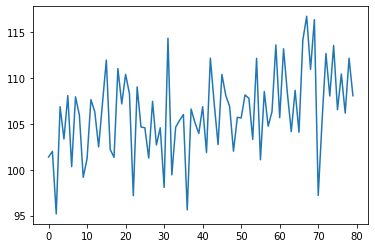

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 870000
episode number : 8120


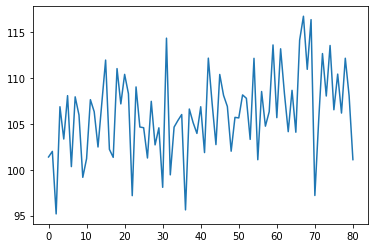

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 880000
episode number : 8213


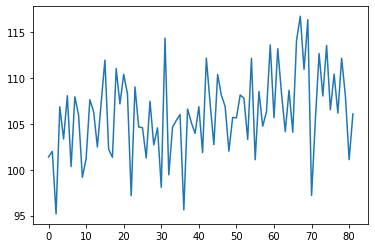

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 890000
episode number : 8310


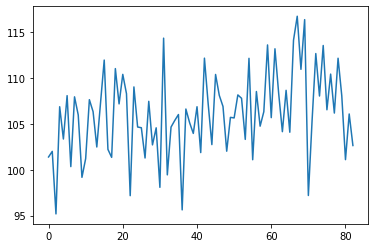

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 900000
episode number : 8401


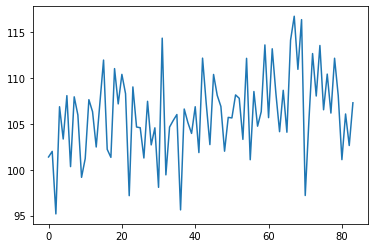

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 910000
episode number : 8497


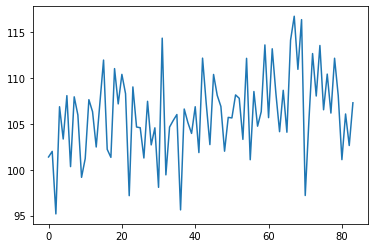

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 920000
episode number : 8592


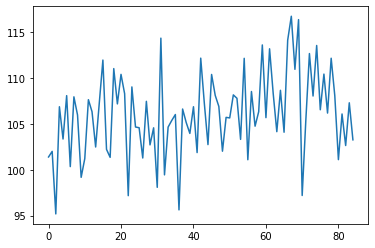

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 930000
episode number : 8689


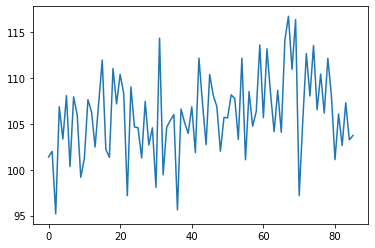

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 940000
episode number : 8781


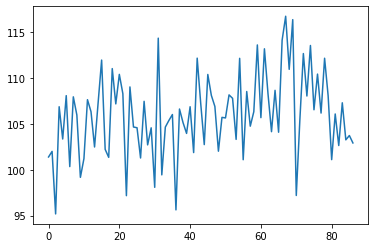

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 950000
episode number : 8871


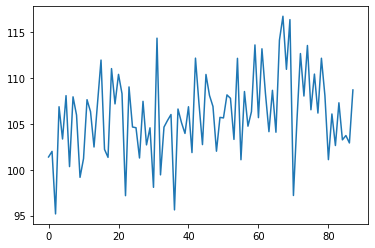

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 960000
episode number : 8970


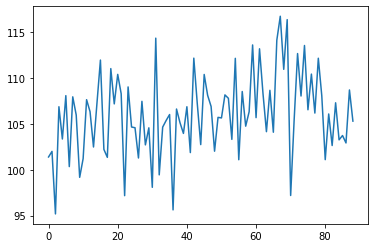

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 970000
episode number : 9055


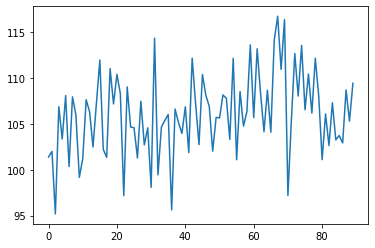

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 980000
episode number : 9152


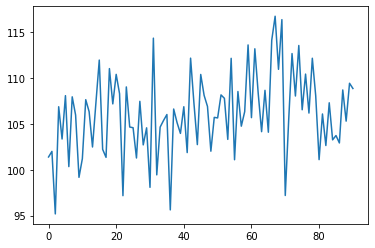

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 990000
episode number : 9240


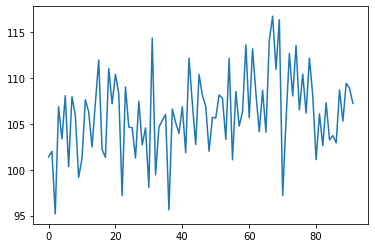

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1000000
episode number : 9335


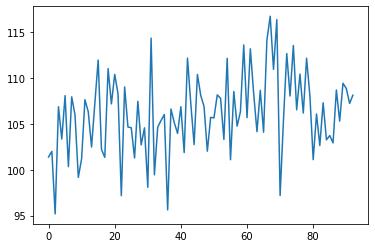

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1010000
episode number : 9424


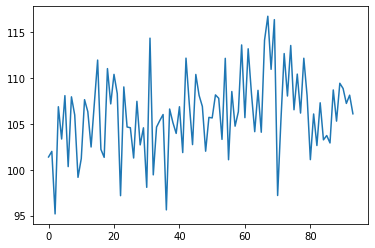

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1020000
episode number : 9516


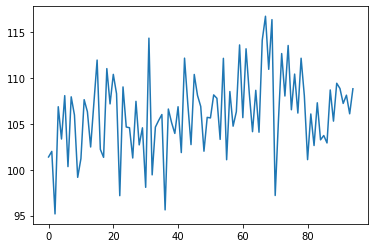

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1030000
episode number : 9608


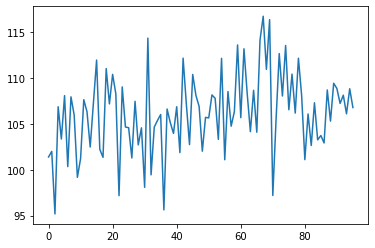

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1040000
episode number : 9700


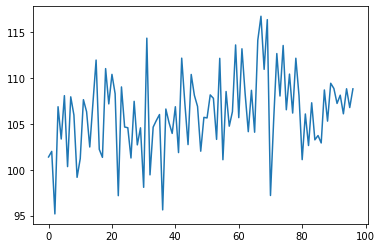

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1050000
episode number : 9794


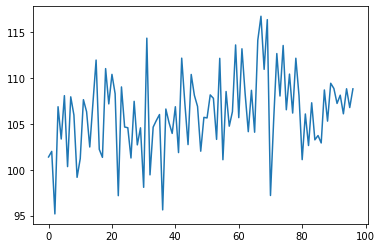

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1060000
episode number : 9884


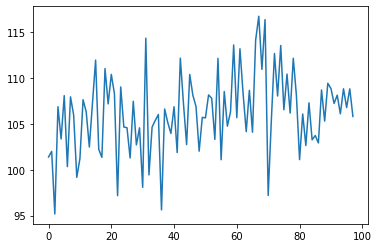

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1070000
episode number : 9968


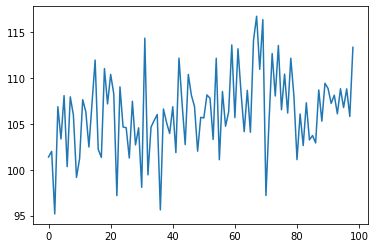

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1080000
episode number : 10058


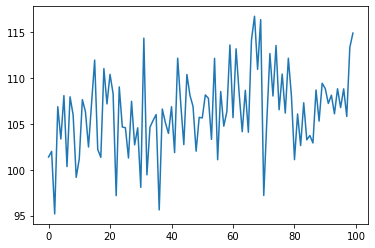

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1090000
episode number : 10144


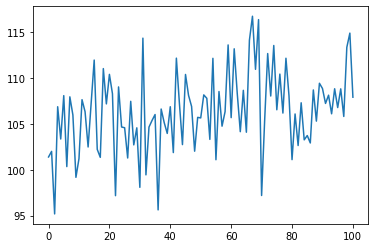

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1100000
episode number : 10233


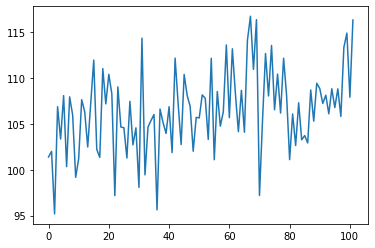

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1110000
episode number : 10324


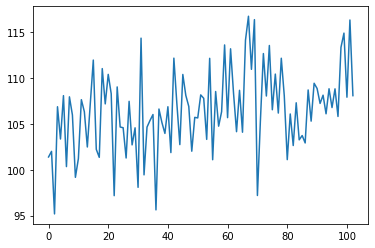

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
step number : 1120000
episode number : 10417


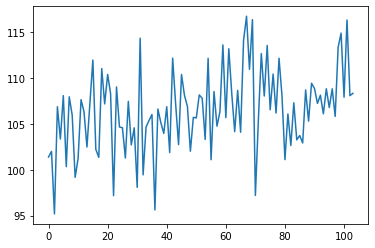

INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets
INFO:tensorflow:Assets written to: tmp_model\assets


In [ ]:
state = env.reset()

episode = 0
total_average_rewards = []
episode_total_rewards = 0
batch_episode_rewards = []

repeat = 0
action_to_repeat = 0

for step in range(2000000):
    # Choose epsilon based on the iteration
    epsilon = max(1 - (step / 62500), 0.01)
    
    """
    #Make 4 steps with same action
    action = action_to_repeat
    if repeat == 0 :
        # Choose the action 
        if random.random() < epsilon:
            action = np.random.randint(3)
        else:
            action = model.predict([state[np.newaxis], np.ones(n_actions).reshape(1, n_actions)])
            action = np.argmax(action, axis=1)
        action_to_repeat = action
        repeat = 3
    else :
        repeat -= 1
    
    """
    
    #Make each independant step
    if random.random() < epsilon:
            action = np.random.randint(3)
    else:
        action = model.predict([state[np.newaxis], np.ones(n_actions).reshape(1, n_actions)])
        action = np.argmax(action, axis=1)
    
    
    # Play one game iteration (note: according to the next paper, you should actually play 4 times here)
    new_frame, reward, is_done, _ = env.step(action)
    replay_buffer.append((state, action, new_frame, reward, is_done))
    episode_total_rewards += reward
    
    if is_done :
        state = env.reset()
        episode += 1
        
        
        batch_episode_rewards = np.append(batch_episode_rewards, episode_total_rewards)
        episode_total_rewards = 0
        if episode % 100 == 0:
            total_average_rewards = np.append(total_average_rewards, np.mean(batch_episode_rewards))
            batch_episode_rewards = []
        
    
    if step % 4 == 0:
        # Sample and fit
        batch = sample_experiences(64)
        fit_batch(model, batch)
    
    if step % 1000 == 0 :
        target = copy_model(model)
        
    if step % 10000 == 0 :
        print("step number : " + str(step))
        print("episode number : " + str(episode))
        model.save('kerasDQL.h5')
        plt.plot(total_average_rewards)
        plt.show()